#### Setup

In [21]:
# tokenization
import json
import MeCab
import demoji
import mojimoji
import re
from stopwords_ja import stop_words
from stopwords_slothlib import stop_words_2

# word2vec
import gensim, logging

# plotting
from sklearn.manifold import TSNE               
import numpy as np                
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#### Clean and Tokenize Tweets

In [ ]:
# tokenize with mecab
mt = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")

# dataset we are working with
year = "2015"

In [ ]:
# preprocess tweet content
def preprocess(text):    
    # from https://colab.research.google.com/drive/1bX-JyY4xmCm_RFkJg3QNcthUvEJaBghP
    # handle half-width/full-width chars, jp punctuation
    text = text.lower()
    text = mojimoji.zen_to_han(text, kana=False)
    text = mojimoji.han_to_zen(text, digit=False, ascii=False)
    text = text.translate(str.maketrans({
        '!': '！', '"': '”', '#': '＃', '$': '＄', '%': '％', '&': '＆', '\'': '’',
        '(': '（', ')': '）', '*': '＊', '+': '＋', ',': '，', '-': '−', '.': '．',
        '/': '／', ':': '：', ';': '；', '<': '＜', '=': '＝', '>': '＞', '?': '？',
        '@': '＠', '[': '［', '\\': '＼', ']': '］', '^': '＾', '_': '＿', '`': '｀',
        '{': '｛', '|': '｜', '}': '｝'
        }))
    zenkaku_leftsingle = b'\xe2\x80\x98'.decode('utf-8')
    text = re.sub('[’´｀]', zenkaku_leftsingle, text)
    
    # remove twitter-specific strings (handles, hashtags, etc.)
    text = re.sub("@([a-zA-Z0-9_]+)", "", text)
    text = re.sub("#([a-zA-Z0-9_ぁ-んァ-ン一-龠]+)", "", text)
    text = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", text)

    # remove emojis
    text = demoji.replace(text, "")
    text = re.sub("([\uD83E-\uD83E])+", "", text)

    # remove punctuation (eng + jp), newlines
    text = re.sub("(\n)+", "", text)
    text = re.sub("([-.,;\"\'!?~@#$%^&*():\{\}\[\]\/\\\\]+)", "", text)
    text = re.sub("([\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\uFF9E-\uFFEE\u3000-\u303F]+)", "", text)
    text = re.sub("([\u25A0-\u25FF])+", "", text)
    text = re.sub("([\u2600-\u26FF])+", "", text)

    return text

In [ ]:
# tokenize cleaned tweets into words
def mecab_tokenize(text):
    parsed = mt.parseToNode(text)
    components = []
    while parsed:
        components.append(parsed.surface)
        parsed = parsed.next
    
    # remove stopwords
    components = [token for token in components if ((not token in stop_words) and (not token in stop_words_2))]
    
    return components

In [22]:
# store results and exception tweets
tokens = []
retweets = []
not_parsed = []

# iterate through tweets, preprocess and tokenize
with open(year + '-all.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        if line == None or tweet == None:
            not_parsed.append((line, tweet))
            print("Parsing error: ", line, tweet)
        elif tweet['retweetedTweet']:
            retweets.append(tweet)
            print("Retweet: ", tweet['id'])
        else: 
            tweet_text = tweet['rawContent'] # note: need other prop for over 140 char?
            # preprocess text
            processed = preprocess(tweet_text)            
            # tokenize with mecab
            components = mecab_tokenize(processed)
            tokens.append(components)

file.close()

In [14]:
# did we get retweets, or did twscrape filter them out?
print(len(retweets))

# did any tweets fail parsing?
print(len(not_parsed))

0
0


#### Word2Vec

In [23]:
# set up logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# train word2vec model
model = gensim.models.Word2Vec(tokens, min_count=10)

2023-12-06 18:36:06,552 : INFO : collecting all words and their counts
2023-12-06 18:36:06,565 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-12-06 18:36:06,633 : INFO : PROGRESS: at sentence #10000, processed 103714 words, keeping 24397 word types
2023-12-06 18:36:06,692 : INFO : PROGRESS: at sentence #20000, processed 210368 words, keeping 34677 word types
2023-12-06 18:36:06,737 : INFO : PROGRESS: at sentence #30000, processed 308540 words, keeping 46082 word types
2023-12-06 18:36:06,778 : INFO : PROGRESS: at sentence #40000, processed 411685 words, keeping 55389 word types
2023-12-06 18:36:06,822 : INFO : PROGRESS: at sentence #50000, processed 513512 words, keeping 63516 word types
2023-12-06 18:36:06,862 : INFO : PROGRESS: at sentence #60000, processed 612734 words, keeping 66317 word types
2023-12-06 18:36:06,918 : INFO : PROGRESS: at sentence #70000, processed 712477 words, keeping 67611 word types
2023-12-06 18:36:06,960 : INFO : PROGRESS: at 

In [16]:
# save word2vec model
model.save("thesis_w2v_" + year + "_tweets")

2023-11-30 11:45:19,091 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'thesis_w2v_2015_tweets', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-11-30T11:45:19.091673', 'gensim': '4.3.2', 'python': '3.11.5 (main, Aug 24 2023, 15:18:16) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5-x86_64-i386-64bit', 'event': 'saving'}
2023-11-30 11:45:19,098 : INFO : not storing attribute cum_table
2023-11-30 11:45:19,182 : INFO : saved thesis_w2v_2015_tweets


In [3]:
# load trained word2vec model
model_2015 = gensim.models.Word2Vec.load("thesis_w2v_2015_tweets")

# check similarity given by trained model
print(model_2015.wv.most_similar(positive='在日',topn=10))
print(model_2015.wv.most_similar(positive='外国人',topn=10))

[('侵攻', 0.8870046734809875), ('破る', 0.8761901259422302), ('人民', 0.8755786418914795), ('岸田文雄', 0.8644543886184692), ('自公', 0.8606095910072327), ('右派', 0.8567697405815125), ('起訴', 0.854092538356781), ('立民', 0.8535529971122742), ('プロパガンダ', 0.8532180786132812), ('朝鮮人', 0.8528974056243896)]
[('日本人', 0.8911892771720886), ('中国人', 0.8543750643730164), ('若者', 0.8528403639793396), ('他国', 0.8411896824836731), ('政治', 0.8321614861488342), ('国', 0.8315311670303345), ('高齢者', 0.8311120867729187), ('移民', 0.8291254639625549), ('国会議員', 0.828331708908081), ('職員', 0.8269411325454712)]


In [4]:
# same for 2022
model_2022 = gensim.models.Word2Vec.load("thesis_w2v_2022_tweets")

print(model_2022.wv.most_similar(positive='在日',topn=10))
print(model_2022.wv.most_similar(positive='外国人',topn=10))


[('侵略者', 0.8887750506401062), ('軍隊', 0.8882155418395996), ('民意', 0.883852481842041), ('略奪', 0.8815134167671204), ('統一協会', 0.8762111663818359), ('全土', 0.8744518756866455), ('陰謀', 0.8732355237007141), ('ネオコン', 0.8732097148895264), ('食糧', 0.8714119791984558), ('裁判官', 0.8696999549865723)]
[('中国人', 0.887516975402832), ('ユダヤ教', 0.870999276638031), ('イスラム教', 0.8588070869445801), ('ユダヤ人', 0.8398546576499939), ('留学生', 0.838367760181427), ('組織', 0.834230899810791), ('欧米', 0.8304198980331421), ('日本人', 0.8295359015464783), ('中国', 0.8283986449241638), ('支持', 0.827479898929596)]


#### Plot Word2Vec Findings

In [6]:
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

def reduce_dimensions(model):
    num_dimensions = 2

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals

In [72]:
# # this plots all words; isn't very useful

# def plot_word2vec(x_vals, y_vals, labels):
#     import matplotlib.pyplot as plt
#     import random

#     random.seed(0)

#     plt.figure(figsize=(50, 50))
#     plt.scatter(x_vals, y_vals)

#     # label randomly subsampled 25 data points
#     fprop = fm.FontProperties(fname='NotoSansJP-VariableFont_wght.ttf')
#     indices = list(range(len(labels)))
#     selected_indices = random.sample(indices, 25)
#     for i in selected_indices:
#         plt.annotate(labels[i], (x_vals[i], y_vals[i]), fontproperties=fprop)

# plot_word2vec(x_vals, y_vals, labels)

In [7]:
# instead, plot similar words only

# https://aneesha.medium.com/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229 
# https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html/
# https://stackoverflow.com/questions/70268270/how-to-plot-tsne-on-word2vec-created-from-gensim-for-the-most-similar-20-cases

def plot_closest_words(word, model, x_vals, y_vals):
    labels = [i for i in model.wv.index_to_key]
    close_words = [i[0] for i in model.wv.most_similar(positive=word, topn=15)]

    fprop = fm.FontProperties(fname='NotoSansJP-VariableFont_wght.ttf')
    for word in close_words:
        i = labels.index(word)
        plt.scatter(x_vals[i],y_vals[i])
        plt.annotate(labels[i], xy=(x_vals[i], y_vals[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontproperties=fprop)

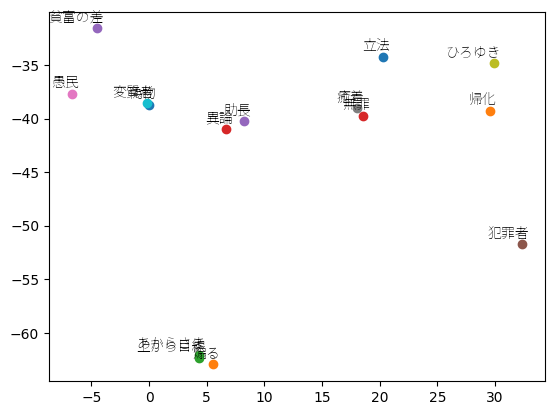

In [8]:
x_vals, y_vals = reduce_dimensions(model_2015)
plot_closest_words("外人", model_2015, x_vals, y_vals)

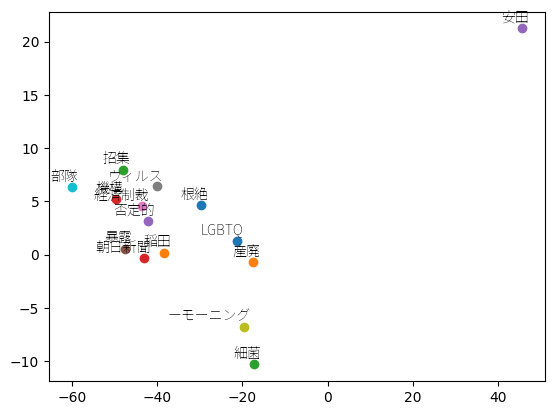

In [9]:
x_vals, y_vals = reduce_dimensions(model_2022)
plot_closest_words("外人", model_2022, x_vals, y_vals)

In [12]:
model_2015.wv.most_similar(positive="外人", topn=15)

[('偽物', 0.7889584302902222),
 ('煽る', 0.7780613303184509),
 ('上から目線', 0.7761332392692566),
 ('異論', 0.7679857015609741),
 ('貧富の差', 0.7679144144058228),
 ('犯罪者', 0.7668929100036621),
 ('愚民', 0.7642369270324707),
 ('癒着', 0.763766884803772),
 ('ひろゆき', 0.7628171443939209),
 ('変質者', 0.7620567083358765),
 ('立法', 0.7617906928062439),
 ('帰化', 0.7605139017105103),
 ('あからさま', 0.7604815363883972),
 ('無罪', 0.7603023648262024),
 ('助長', 0.7593064904212952)]

In [13]:
model_2022.wv.most_similar(positive="外人", topn=15)

[('LGBTQ', 0.751596212387085),
 ('稲田', 0.7500256299972534),
 ('細菌', 0.7422671914100647),
 ('機構', 0.7371512651443481),
 ('否定的', 0.7297788262367249),
 ('暴露', 0.7273468971252441),
 ('経済制裁', 0.7269293069839478),
 ('ウィルス', 0.7266963124275208),
 ('ーモーニング', 0.7257336974143982),
 ('部隊', 0.7246589660644531),
 ('根絶', 0.721153974533081),
 ('産廃', 0.7185984253883362),
 ('招集', 0.7185619473457336),
 ('朝日新聞', 0.718533456325531),
 ('安田', 0.717850923538208)]

In [17]:
words = model_2015.wv.most_similar(positive="在日", topn=15)
for word in words:
    print(word[0])

侵攻
破る
人民
岸田文雄
自公
右派
起訴
立民
プロパガンダ
朝鮮人
虐殺
窃盗
警視庁
ハブ
追放


In [18]:
words = model_2022.wv.most_similar(positive="在日", topn=15)
for word in words:
    print(word[0])

侵略者
軍隊
民意
略奪
統一協会
全土
陰謀
ネオコン
食糧
裁判官
売国奴
自治区
巻き添え
追い出さ
無辜


In [ ]:
words = model_2015.wv.most_similar(positive="在日", topn=15)
for word in words:
    print(word[0])

In [ ]:
words = model_2022.wv.most_similar(positive="在日", topn=15)
for word in words:
    print(word[0])

In [19]:
model_2015.wv.index_to_key[:50]

['…',
 'ね',
 'ござい',
 'よ',
 'てる',
 'けど',
 'たら',
 'さん',
 'おはよう',
 'まし',
 'ありがとう',
 '・',
 'って',
 'たい',
 '今日',
 'ご',
 'ー',
 'いい',
 '見',
 '人',
 'そう',
 'とか',
 'おは',
 'ください',
 'くれ',
 '気',
 '方',
 'ちゃん',
 'だけ',
 'フォロー',
 '参加',
 '中',
 '思っ',
 '日',
 '自分',
 'すぎ',
 'ω',
 '時',
 '今',
 'やっ',
 'み',
 'じゃ',
 'でし',
 '好き',
 '笑',
 'w',
 'わ',
 'お願い',
 '応募',
 '来']

In [20]:
model_2022.wv.index_to_key[:50]

['…',
 'ね',
 'ござい',
 'よ',
 'てる',
 'けど',
 'おはよう',
 'さん',
 'まし',
 'たら',
 'ありがとう',
 'って',
 '今日',
 'たい',
 '・',
 '人',
 'ー',
 'そう',
 '見',
 'いい',
 'ご',
 'ください',
 'おは',
 '方',
 'とか',
 'だけ',
 'ちゃん',
 'くれ',
 '今',
 '思っ',
 '日',
 '参加',
 'すぎ',
 'w',
 'でし',
 '気',
 '自分',
 'み',
 '結果',
 '時',
 '笑',
 '中',
 '好き',
 'やっ',
 'ω',
 'わ',
 'ませ',
 'じゃ',
 '️',
 '良い']